# Student Name: Saeedreza Zouashkiani
# Student ID: 400206262

In [1]:
# Load necessary libraries and load device
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch 
import matplotlib.pyplot as plt
import string
from torchvision import transforms
from torch import optim
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

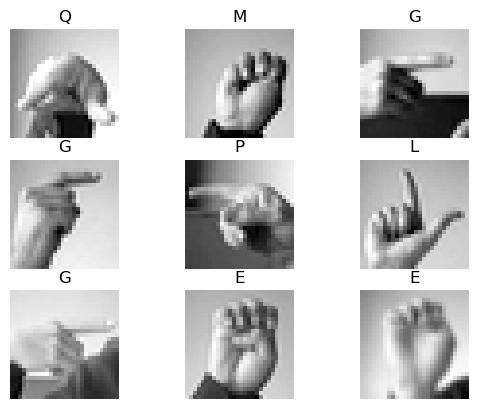

In [2]:
# Load alphabet into a list and create a dictionary to map each letter to a number
alphabet = list(string.ascii_uppercase)[:25]
num2letter = {num: letter for num, letter in enumerate(alphabet)}
# Load q3_train.csv and plot 9 random images with their labels
df = pd.read_csv('./DL_HW2/Data/HW2_data/Q3_train.csv')
df = df.sample(frac=1)
df = df.reset_index(drop=True)
df = df[:9]
df = df.reset_index(drop=True)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(df.iloc[i, 1:].values.reshape(28, 28), cmap='gray')
    plt.title(num2letter[df.iloc[i, 0]])
    plt.axis('off')
plt.show()


In [3]:
# create a custom dataset class to load the data from q3_train.csv and q3_test.csv
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x = self.data.iloc[idx, 1:].values.astype('float32')
        y = self.data.iloc[idx, 0]
        if self.transform:
            x = self.transform(x)
        return x, y

# create a custom transform class to normalize the data
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        return (sample - self.mean) / self.std     

In [4]:
# define a transform to normalize the data
transform = transforms.Compose([Normalize(0.5, 0.5)])

# Load q3_train.csv and shuffle the data and split it into train and validation sets
trainset = CustomDataset('./DL_HW2/Data/HW2_data/Q3_train.csv', transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [int(0.8*len(trainset)), int(0.2*len(trainset))],
generator=torch.Generator().manual_seed(42))
testset = CustomDataset('./DL_HW2/Data/HW2_data/Q3_test.csv', transform=transform)
# create dataloaders for train and validation and test sets
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [16]:
# define an MLP model with 2 hidden layers
# there are 25 classes in the dataset

class MLP(nn.Module):
    def __init__(self, in_features, hidden_size, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [17]:
# define a function to train the model and return the training and validation losses and accuracies
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0
        train_acc = 0
        val_acc = 0
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (output.argmax(1) == y).type(torch.float).mean().item()
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                output = model(x)
                loss = criterion(output, y)
                val_loss += loss.item()
                val_acc += (output.argmax(1) == y).type(torch.float).mean().item()
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        train_accs.append(train_acc/len(train_loader))
        val_accs.append(val_acc/len(val_loader))
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss/len(train_loader), val_loss/len(val_loader), train_acc/len(train_loader), val_acc/len(val_loader)))
    return train_losses, val_losses, train_accs, val_accs

In [18]:
# define a function to test the model and return the test loss and accuracy
def test_model(model, test_loader, criterion):
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss = criterion(output, y)
            test_loss += loss.item()
            test_acc += (output.argmax(1) == y).type(torch.float).mean().item()
    print('Test Loss: {:.6f} \tTest Accuracy: {:.6f}'.format(test_loss/len(test_loader), test_acc/len(test_loader)))
    return test_loss/len(test_loader), test_acc/len(test_loader)

In [19]:
# define the loss function
criterion = nn.CrossEntropyLoss()

In [20]:
# Choose the best learning rate for Adam optimizer
learning_rates = [1e-5, 3e-5,1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for lr in learning_rates:
    model = MLP(784, 256, 25).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=2)
    train_losses.append(train_loss[-1])
    val_losses.append(val_loss[-1])
    train_accs.append(train_acc[-1])
    val_accs.append(val_acc[-1])

# choose the best learning rate
best_lr_Adam = learning_rates[np.argmax(val_accs)]
print('Best learning rate: {}'.format(best_lr_Adam))

Epoch: 1 	Training Loss: 5.037997 	Validation Loss: 2.776683 	Training Accuracy: 0.132389 	Validation Accuracy: 0.258778
Epoch: 2 	Training Loss: 2.278950 	Validation Loss: 1.890236 	Training Accuracy: 0.355666 	Validation Accuracy: 0.448871
Epoch: 1 	Training Loss: 3.276054 	Validation Loss: 1.627077 	Training Accuracy: 0.305217 	Validation Accuracy: 0.526095
Epoch: 2 	Training Loss: 1.282326 	Validation Loss: 1.030269 	Training Accuracy: 0.620897 	Validation Accuracy: 0.684985
Epoch: 1 	Training Loss: 2.456172 	Validation Loss: 1.110781 	Training Accuracy: 0.411791 	Validation Accuracy: 0.646874
Epoch: 2 	Training Loss: 0.852150 	Validation Loss: 0.547979 	Training Accuracy: 0.732361 	Validation Accuracy: 0.841698
Epoch: 1 	Training Loss: 2.411947 	Validation Loss: 1.118420 	Training Accuracy: 0.399361 	Validation Accuracy: 0.618944
Epoch: 2 	Training Loss: 0.814528 	Validation Loss: 0.600338 	Training Accuracy: 0.732376 	Validation Accuracy: 0.806084
Epoch: 1 	Training Loss: 3.75981

In [21]:
# choose best learning rate for SGD optimizer
learning_rates = [1e-5, 3e-5,1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for lr in learning_rates:
    model = MLP(784, 256, 25).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=2)
    train_losses.append(train_loss[-1])
    val_losses.append(val_loss[-1])
    train_accs.append(train_acc[-1])
    val_accs.append(val_acc[-1])
# choose the best learning rate
best_lr_SGD = learning_rates[np.argmax(val_accs)]
print('Best learning rate: {}'.format(best_lr_SGD))

Epoch: 1 	Training Loss: 4.936644 	Validation Loss: 3.373325 	Training Accuracy: 0.096218 	Validation Accuracy: 0.153674
Epoch: 2 	Training Loss: 3.033352 	Validation Loss: 2.798422 	Training Accuracy: 0.194692 	Validation Accuracy: 0.241835
Epoch: 1 	Training Loss: 3.970195 	Validation Loss: 3.029601 	Training Accuracy: 0.141594 	Validation Accuracy: 0.221892
Epoch: 2 	Training Loss: 2.419377 	Validation Loss: 2.234050 	Training Accuracy: 0.300675 	Validation Accuracy: 0.333768
Epoch: 1 	Training Loss: 3.042595 	Validation Loss: 2.298395 	Training Accuracy: 0.252922 	Validation Accuracy: 0.329956
Epoch: 2 	Training Loss: 1.719402 	Validation Loss: 1.884160 	Training Accuracy: 0.481725 	Validation Accuracy: 0.447560
Epoch: 1 	Training Loss: 2.738424 	Validation Loss: 2.545181 	Training Accuracy: 0.314075 	Validation Accuracy: 0.252971
Epoch: 2 	Training Loss: 1.375375 	Validation Loss: 2.264735 	Training Accuracy: 0.577837 	Validation Accuracy: 0.407586
Epoch: 1 	Training Loss: 4.36522

In [23]:
# define the model save the best model based on the validation accuracy
model_Adam = MLP(784, 256, 25).to(device)
optimizer = optim.Adam(model_Adam.parameters(), lr=best_lr_Adam)
train_losses_Adam, val_losses_Adam, train_accs_Adam, val_accs_Adam = train_model(model_Adam, train_loader, val_loader, criterion, optimizer, epochs=20)
test_loss_Adam, test_acc_Adam = test_model(model_Adam, test_loader, criterion)
torch.save(model_Adam.state_dict(), './model_Adam.pt')

Epoch: 1 	Training Loss: 2.256342 	Validation Loss: 1.037928 	Training Accuracy: 0.427538 	Validation Accuracy: 0.671861
Epoch: 2 	Training Loss: 0.705413 	Validation Loss: 0.574077 	Training Accuracy: 0.784278 	Validation Accuracy: 0.813900
Epoch: 3 	Training Loss: 0.337181 	Validation Loss: 0.198462 	Training Accuracy: 0.907386 	Validation Accuracy: 0.956210
Epoch: 4 	Training Loss: 0.176212 	Validation Loss: 0.097496 	Training Accuracy: 0.956259 	Validation Accuracy: 0.987100
Epoch: 5 	Training Loss: 0.078371 	Validation Loss: 0.103023 	Training Accuracy: 0.987827 	Validation Accuracy: 0.973791
Epoch: 6 	Training Loss: 0.037401 	Validation Loss: 0.021869 	Training Accuracy: 0.996457 	Validation Accuracy: 0.999273
Epoch: 7 	Training Loss: 0.017240 	Validation Loss: 0.016866 	Training Accuracy: 0.999455 	Validation Accuracy: 0.998728
Epoch: 8 	Training Loss: 0.140776 	Validation Loss: 0.021926 	Training Accuracy: 0.956668 	Validation Accuracy: 0.998183
Epoch: 9 	Training Loss: 0.01094

In [24]:
# define the model and save the best model based on the validation accuracy
model_SGD = MLP(784, 256, 25).to(device)
optimizer = optim.SGD(model_SGD.parameters(), lr=best_lr_SGD)
train_losses_SGD, val_losses_SGD, train_accs_SGD, val_accs_SGD = train_model(model_SGD, train_loader, val_loader, criterion, optimizer, epochs=20)
test_loss_SGD, test_acc_SGD = test_model(model_SGD, test_loader, criterion)
torch.save(model_SGD.state_dict(), './model_SGD.pt')

Epoch: 1 	Training Loss: 3.002783 	Validation Loss: 2.519897 	Training Accuracy: 0.272363 	Validation Accuracy: 0.290117
Epoch: 2 	Training Loss: 1.684017 	Validation Loss: 1.893631 	Training Accuracy: 0.496805 	Validation Accuracy: 0.446467
Epoch: 3 	Training Loss: 1.293214 	Validation Loss: 1.544855 	Training Accuracy: 0.617263 	Validation Accuracy: 0.523690
Epoch: 4 	Training Loss: 1.057929 	Validation Loss: 1.047915 	Training Accuracy: 0.692799 	Validation Accuracy: 0.669274
Epoch: 5 	Training Loss: 0.895791 	Validation Loss: 1.057823 	Training Accuracy: 0.747366 	Validation Accuracy: 0.676268
Epoch: 6 	Training Loss: 0.773755 	Validation Loss: 1.039440 	Training Accuracy: 0.786216 	Validation Accuracy: 0.663179
Epoch: 7 	Training Loss: 0.677775 	Validation Loss: 0.697968 	Training Accuracy: 0.818026 	Validation Accuracy: 0.809949
Epoch: 8 	Training Loss: 0.598617 	Validation Loss: 0.988270 	Training Accuracy: 0.842948 	Validation Accuracy: 0.700799
Epoch: 9 	Training Loss: 0.52905

In [27]:
# define a new model like MLP but with dropout
class MLP_dropout(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_dropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.1)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [14]:
# choose best learning rate for Adam optimizer for MLP_dropout
learning_rates = [1e-5, 3e-5,1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for lr in learning_rates:
    model = MLP_dropout(784, 256, 25).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=2)
    train_losses.append(train_loss[-1])
    val_losses.append(val_loss[-1])
    train_accs.append(train_acc[-1])
    val_accs.append(val_acc[-1])
# choose the best learning rate
best_lr_Adam_dropout = learning_rates[np.argmax(val_accs)]
print('Best learning rate: {}'.format(best_lr_Adam_dropout))

Epoch: 1 	Training Loss: 17.386320 	Validation Loss: 3.359341 	Training Accuracy: 0.064741 	Validation Accuracy: 0.149581
Epoch: 2 	Training Loss: 3.428652 	Validation Loss: 2.854365 	Training Accuracy: 0.110692 	Validation Accuracy: 0.187874
Epoch: 3 	Training Loss: 3.035169 	Validation Loss: 2.677046 	Training Accuracy: 0.138354 	Validation Accuracy: 0.238244
Epoch: 4 	Training Loss: 2.879139 	Validation Loss: 2.558728 	Training Accuracy: 0.170376 	Validation Accuracy: 0.263185
Epoch: 1 	Training Loss: 8.703061 	Validation Loss: 2.793773 	Training Accuracy: 0.092493 	Validation Accuracy: 0.200952
Epoch: 2 	Training Loss: 2.836747 	Validation Loss: 2.315851 	Training Accuracy: 0.184093 	Validation Accuracy: 0.340768
Epoch: 3 	Training Loss: 2.440804 	Validation Loss: 1.913324 	Training Accuracy: 0.282885 	Validation Accuracy: 0.439153
Epoch: 4 	Training Loss: 2.126250 	Validation Loss: 1.578844 	Training Accuracy: 0.358512 	Validation Accuracy: 0.524410
Epoch: 1 	Training Loss: 5.6461

In [29]:
#  train the model with the best learning rate and save the best model based on the validation accuracy
model_Adam_dropout = MLP_dropout(784, 256, 25).to(device)
optimizer = optim.Adam(model_Adam_dropout.parameters(), lr=1e-4)
train_losses_Adam_dropout, val_losses_Adam_dropout, train_accs_Adam_dropout, val_accs_Adam_dropout = train_model(model_Adam_dropout, train_loader, val_loader, criterion, optimizer, epochs=20)
test_loss_Adam_dropout, test_acc_Adam_dropout = test_model(model_Adam_dropout, test_loader, criterion)
torch.save(model_Adam_dropout.state_dict(), './model_Adam_dropout.pt')


Epoch: 1 	Training Loss: 3.072286 	Validation Loss: 1.424754 	Training Accuracy: 0.260704 	Validation Accuracy: 0.577106
Epoch: 2 	Training Loss: 1.472191 	Validation Loss: 0.847313 	Training Accuracy: 0.526284 	Validation Accuracy: 0.745265
Epoch: 3 	Training Loss: 1.025154 	Validation Loss: 0.607237 	Training Accuracy: 0.663654 	Validation Accuracy: 0.819397
Epoch: 4 	Training Loss: 0.779927 	Validation Loss: 0.393165 	Training Accuracy: 0.737494 	Validation Accuracy: 0.890208
Epoch: 5 	Training Loss: 0.598822 	Validation Loss: 0.258110 	Training Accuracy: 0.801826 	Validation Accuracy: 0.932591
Epoch: 6 	Training Loss: 0.466976 	Validation Loss: 0.173106 	Training Accuracy: 0.845506 	Validation Accuracy: 0.965070
Epoch: 7 	Training Loss: 0.393192 	Validation Loss: 0.156502 	Training Accuracy: 0.868762 	Validation Accuracy: 0.965932
Epoch: 8 	Training Loss: 0.338897 	Validation Loss: 0.134169 	Training Accuracy: 0.887203 	Validation Accuracy: 0.967977
Epoch: 9 	Training Loss: 0.29473

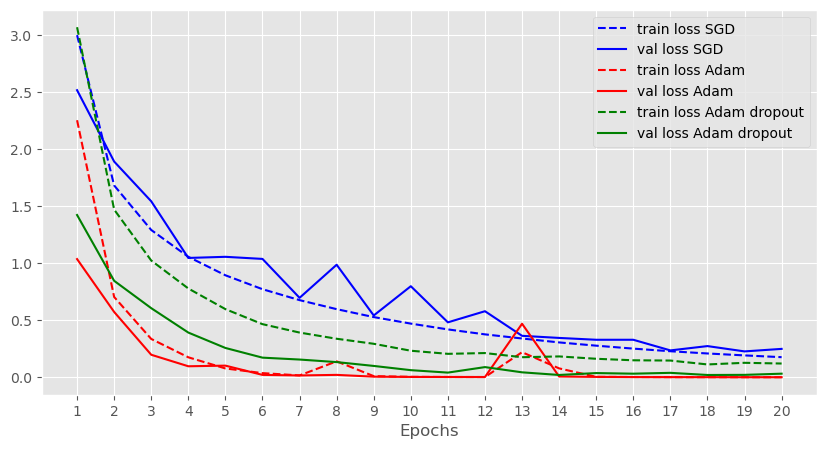

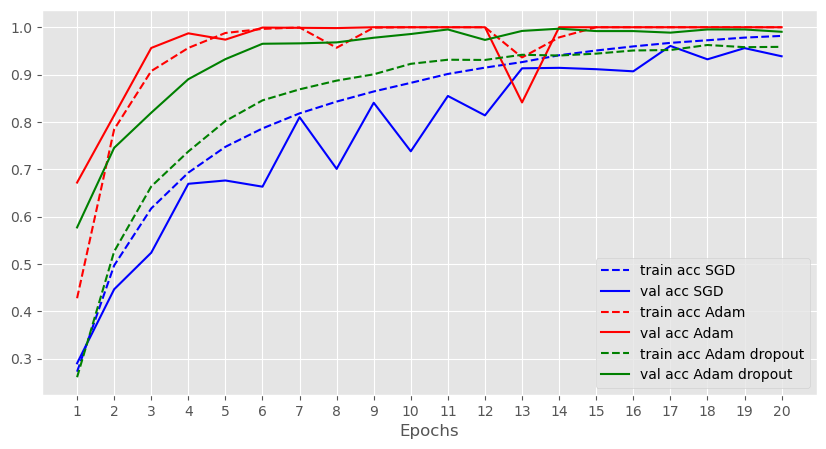

In [43]:

# plot the training and validation loss curves for MLP_SGD, MLP_Adam, MLP_Adam_dropout
# set the plot style to ggplot
plt.style.use('ggplot')
r = np.arange(1, 21, 1)
plt.figure(figsize=(10, 5))
plt.plot(r, train_losses_SGD, 'b--', label='train loss SGD')
plt.plot(r, val_losses_SGD, 'b', label='val loss SGD')
plt.plot(r, train_losses_Adam, 'r--', label='train loss Adam')
plt.plot(r, val_losses_Adam, 'r', label='val loss Adam')
plt.plot(r, train_losses_Adam_dropout, 'g--', label='train loss Adam dropout')
plt.plot(r, val_losses_Adam_dropout, 'g', label='val loss Adam dropout')
plt.legend()
plt.xlabel('Epochs')
# set the x axis to be from 0 to 20 with step size 1
plt.xticks(np.arange(1, 21, 1))

# plot the training and validation accuracy curves for MLP_SGD, MLP_Adam, MLP_Adam_dropout
plt.figure(figsize=(10, 5))
plt.plot(r, train_accs_SGD, 'b--', label='train acc SGD')
plt.plot(r, val_accs_SGD, 'b', label='val acc SGD')
plt.plot(r, train_accs_Adam, 'r--', label='train acc Adam')
plt.plot(r, val_accs_Adam, 'r', label='val acc Adam')
plt.plot(r, train_accs_Adam_dropout, 'g--', label='train acc Adam dropout')
plt.plot(r, val_accs_Adam_dropout, 'g', label='val acc Adam dropout')
plt.legend()
plt.xlabel('Epochs')
plt.xticks(np.arange(1, 21, 1))
plt.show()


The model is trained for 20 epochs for 3 cases.
1) MLP without dropout with Adam optimizer.
2) MLP without dropout with SGD optimizer.
3) MLP with dropout with Adam optimizer.

The loss and accuracy plots are shown above.
Adam optimizer converges faster than SGD optimizer because of its adaptive learning rate and momentum. SGD suffers from slow convergence and high variance. 

Dropout is used to prevent overfitting. It is a regularization technique that randomly drops out units (along with their connections) from the neural network during training. It forces the network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons. It is a very effective and simple method for regularization and preventing overfitting in neural networks. As is seen in the plots, the loss and accuracy curves are smoother than the other two cases.


The model with dropout and Adam optimizer is the best model for this dataset. It has the lowest loss and highest accuracy. It is the best model because it has the best trade-off between bias and variance.